### Objective:  In this notebook, I am doing a grid search for Gradient Boosted Trees

I will do the grid search using 10 fold CV on a subset of the training data. 

### Load modules and the data

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, make_scorer

import numpy as np
import pandas as pd
import seaborn as sns
from os.path import join, split
from os import listdir
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows',999)
pd.set_option('display.max_columns', 999)
%matplotlib inline

In [4]:
base = join('/Users/crivera5/Documents/NonIntuitProjects/Kaggle/KaggleEEG','data_local')
data= pd.read_csv(join(base,'cleaned_training.csv'))

X = data.iloc[:, :-3].copy()
y = data.iloc[:,-1].copy()

### Split the data into test and train


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=4)

In [85]:
y.value_counts()

0    3601
1     384
Name: pre_ictal, dtype: int64

### Set up the pipeline and fit the data

The pipeline below: 

1. scales the data, (I don't technically need to do the scalling for the trees but it should not hurt)
2. Trains a GradientBoostedClassfier with GridSearchCV. (this is just to train multiple trees with more cores)

I am trying 3 different parameters in my grid search: 
1. max_features: “sqrt” or None  (all the features or the sqrt)
2. max_depth: 3, 6
3. subsample: 0.75,0.9   #chose these randomly

I'll try 250 trees

In [12]:
# the space to search 
cv = 10
scalar = StandardScaler()

clf = GradientBoostingClassifier(n_estimators=250, 
                                 subsample=0.9,
                                 max_depth=3, 
                                 random_state=444, 
                                 max_features=None)

pipeline = Pipeline([('scalar',StandardScaler()),
                     ('clf', clf)])
parameters = {'clf__subsample':[0.75,0.9], 
              'clf__max_depth':[3,6],
              'clf__max_features':['sqrt',None]}

model = GridSearchCV(pipeline, parameters, n_jobs = -1, scoring = 'roc_auc',verbose = True, cv = cv)
model

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(steps=[('scalar', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1...s=250, presort='auto', random_state=444,
              subsample=0.9, verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'clf__max_features': ['sqrt', None], 'clf__max_depth': [3, 6], 'clf__subsample': [0.75, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=True)

In [13]:
model.fit(X_train, y_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  9.5min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(steps=[('scalar', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1...s=250, presort='auto', random_state=444,
              subsample=0.9, verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'clf__max_features': ['sqrt', None], 'clf__max_depth': [3, 6], 'clf__subsample': [0.75, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=True)

### Get the best estimator of the bunch

Below I am getting the best model of the bunch. 

In [14]:
best_model  = model.best_estimator_

In [16]:
best_model.get_params()

{'clf': GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='deviance', max_depth=6,
               max_features='sqrt', max_leaf_nodes=None,
               min_impurity_split=1e-07, min_samples_leaf=1,
               min_samples_split=2, min_weight_fraction_leaf=0.0,
               n_estimators=250, presort='auto', random_state=444,
               subsample=0.9, verbose=0, warm_start=False),
 'clf__criterion': 'friedman_mse',
 'clf__init': None,
 'clf__learning_rate': 0.1,
 'clf__loss': 'deviance',
 'clf__max_depth': 6,
 'clf__max_features': 'sqrt',
 'clf__max_leaf_nodes': None,
 'clf__min_impurity_split': 1e-07,
 'clf__min_samples_leaf': 1,
 'clf__min_samples_split': 2,
 'clf__min_weight_fraction_leaf': 0.0,
 'clf__n_estimators': 250,
 'clf__presort': 'auto',
 'clf__random_state': 444,
 'clf__subsample': 0.9,
 'clf__verbose': 0,
 'clf__warm_start': False,
 'scalar': StandardScaler(copy=True, with_mean=True, with_std=True),
 'scalar__

### Plot an ROC curve

In [17]:
def plot_roc_curves(model_data, lw = 0.8):
    '''plots an roc curve
    Parameters: 
        model_data: dicts obs and probs
        classifier
    Returns: 
        None
    '''
    for model in model_data:
        print model
        obs = model_data[model]['obs']
        probs = model_data[model]['probs']
        fpr, tpr, _= roc_curve(obs, probs)
        
        plt.plot(fpr, tpr,label = model, lw=lw)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curves')
    plt.legend(loc = 0)
    
    return None

In [19]:
probs = [pred[1] for pred in best_model.predict_proba(X_test)]
model_data = {'Best GradientBoostedForest': {'obs':y_test,
                                              'probs': probs}}

Best GradientBoostedForest


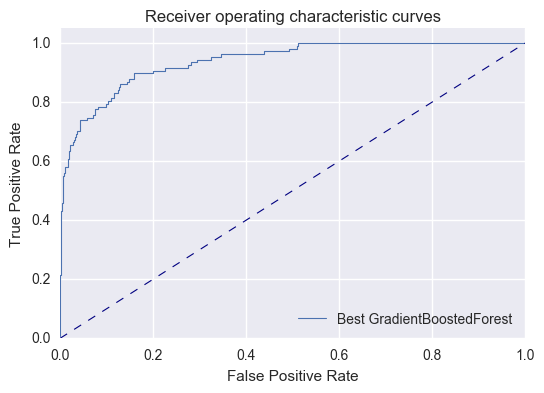

In [20]:
plot_roc_curves(model_data)

In [54]:
roc_auc_score(y_test, probs)

0.93990339178830196

### Plot a the AUC as a function of the number of trees. 

In [48]:
scale = best_model.get_params()['scalar']
trees = best_model.get_params()['clf']


X_transformed = scale.transform(X_test)
scores =pd.Series([roc_auc_score(y_test,score[:,1]) for score in trees.staged_predict_proba(X_transformed)])


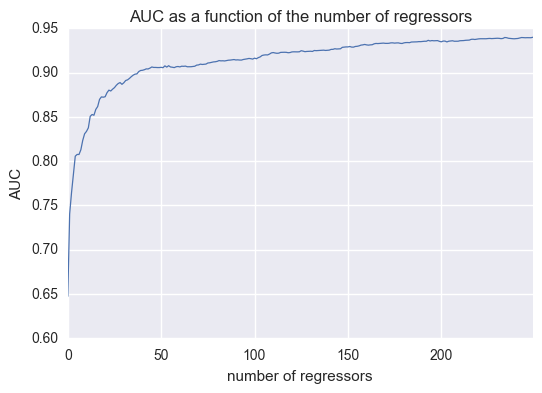

In [53]:
ax = scores.plot(lw=0.9)
ax.set_xlabel('number of regressors')
ax.set_ylabel('AUC')
ax.set_title('AUC as a function of the number of regressors')

In [83]:
### Plot the feature importances

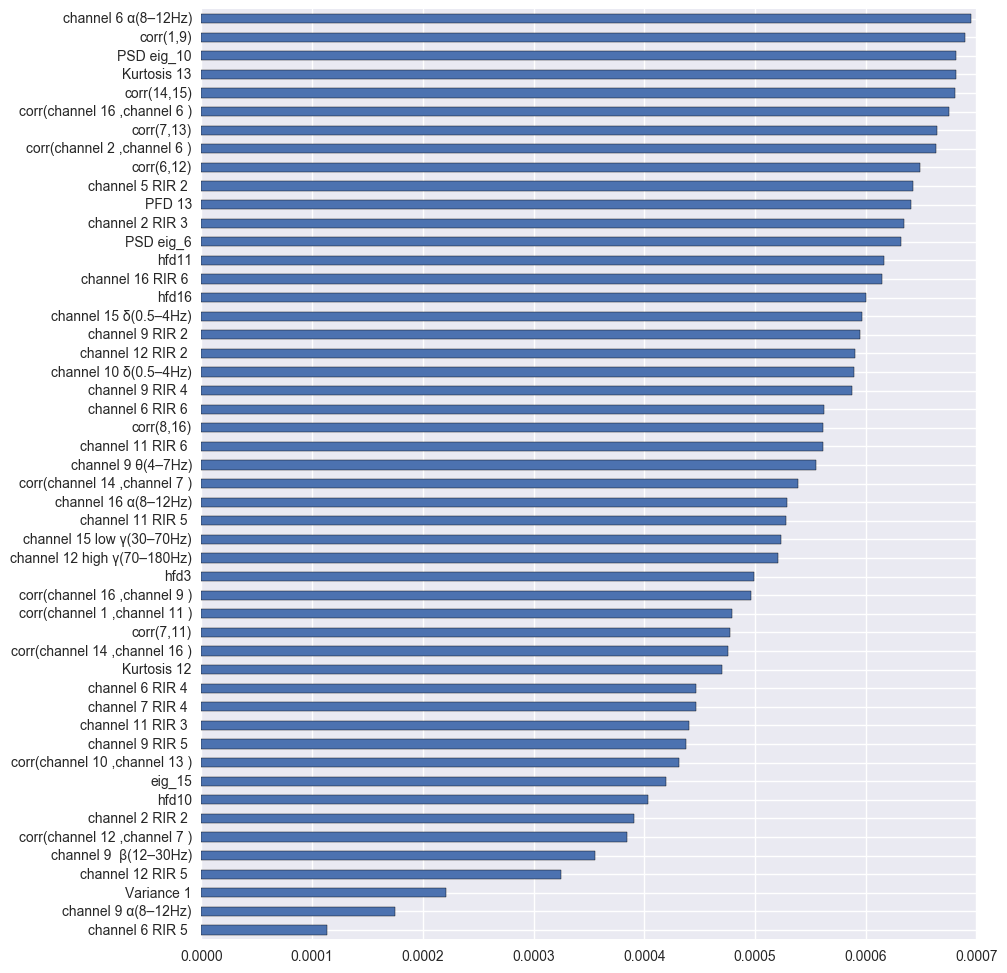

In [82]:
importances =pd.Series(trees.feature_importances_, index = X.columns)
importances.sort_values(inplace=True)
importances[:50].plot.barh(figsize = (10,12))

## Retrain the model with all the data and save

In [55]:
best_model.fit(X,y)
# save the model
from sklearn.externals import joblib
filename = join(base,'GradientBoostedModel.joblib.pkl')
joblib.dump(best_model, filename, compress=3)

['/Users/crivera5/Documents/NonIntuitProjects/Kaggle/KaggleEEG/data_local/GradientBoostedModel.joblib.pkl']

### Predict the test data

In [57]:
def load_features(path):
    """loads the features of the data and removes undesired columns """
    
    remove = ['channel 4 RIR 1 ', 'channel 4 RIR 2 ', 'channel 4 RIR 3 ', 'channel 4 RIR 4 ', 'channel 4 RIR 5 ',
              'channel 4 RIR 6 ', 'channel 10 RIR 1 ', 'channel 10 RIR 2 ', 'channel 10 RIR 3 ', 'channel 10 RIR 4 ',
              'channel 10 RIR 5 ', 'channel 10 RIR 6 ', 'SpectralEntropy 4', 'SpectralEntropy 10']
    
    # read in the data 
    data =pd.read_csv(path)
        
    # drop the undesired columns 
    return data.drop(remove, axis = 1)


test_data = load_features(join(base,'testing.csv'))

In [58]:
X_testing = test_data.iloc[:,:-1].copy()
file_names = test_data['filename'].copy()

In [59]:
# There are Nan's so fill them
X_testing =X_testing.fillna(X_testing.mean(),axis = 0)

In [60]:
predictions = [pred[1] for pred in best_model.predict_proba(X_testing)]

In [61]:
submission = pd.DataFrame({'File':file_names, 'Class': predictions})
submission = submission[['File','Class']]

In [62]:
submission.head()

,File,Class
0,new_1_1.mat,0.311668
1,new_1_10.mat,0.021410
2,new_1_100.mat,0.835433
3,new_1_101.mat,0.142998
4,new_1_102.mat,0.023823


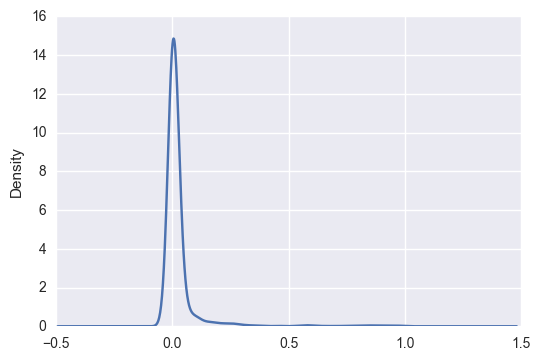

In [63]:
submission.Class.plot.density()

I doubt tha this works well. I should balance the data prior to doing the prediction. Its just to imbalanced... for it work. This will predict that the majority are non ictal which is not the case. 

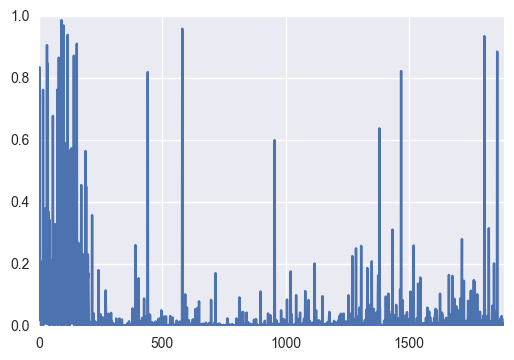

In [64]:
submission.Class.plot()

In [65]:
len(submission)

1888

### Get files not in the data
The problem with this is that i did not have all the files. 

In [66]:
base2 = join('/Users/crivera5/Documents/NonIntuitProjects/Kaggle/KaggleEEG')
paths = [join(base2, 'test_1_new'), 
         join(base2,'test_2_new'),
         join(base2,'test_3_new')]

In [67]:
def get_data_files(list_o_paths):
    """This gets the data matlab files"""
    file_names = []
    for path in list_o_paths:
        files = [join(path, f) for f in listdir(path) if f.endswith('.mat')]
        file_names.extend(files)

    return file_names

In [68]:
unscored_files = [split(f)[1] for f in get_data_files(paths)]
unscored_files = [f for f in unscored_files if f not in list(submission['File'])]
unscored_files =pd.DataFrame({'File':unscored_files})
unscored_files['Class'] = submission.Class.mean()
unscored_files.head()

,File,Class
0,new_1_13.mat,0.028906
1,new_1_147.mat,0.028906
2,new_1_167.mat,0.028906
3,new_1_177.mat,0.028906
4,new_1_18.mat,0.028906


In [69]:
# merge them 
submission = pd.concat([submission, unscored_files])
submission.sort_values('File', inplace = True)

In [70]:
print len(submission)
submission.head()


1908


,File,Class
0,new_1_1.mat,0.311668
1,new_1_10.mat,0.021410
2,new_1_100.mat,0.835433
3,new_1_101.mat,0.142998
4,new_1_102.mat,0.023823


In [71]:
submission.to_csv(join(base,'submission3.csv'), index = False)

### Likely not going to submit

In [93]:
best_model.fit(X_train,y_train)

Pipeline(steps=[('scalar', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=6,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_split...s=250, presort='auto', random_state=444,
              subsample=0.9, verbose=0, warm_start=False))])

In [94]:
preds = pd.Series(best_model.predict(X_test))
preds.value_counts()

0    964
1     33
dtype: int64

In [103]:
best_model.score(X_test, y_test)

0.92176529588766298

In [104]:
y_test.value_counts()/len(y_test)

0    0.892678
1    0.107322
Name: pre_ictal, dtype: float64